### Author: Md Fahim Hasan
### Work Email: mdfahim.hasan@bayer.com

# Read me

The weather and satellite `100m Analytical Ready Data (ARD)`s consists of the folowing datasets-
  1. min temperature
  2. max temperature
  3. average temperature
  4. average wind speed
  5. average relative humidity
  6. total precipitation (modeled or resampled) **
  7. min relative humidity
  8. max relative humidity
  9. total net solar radiation
  10. Satellite LST data

From these variables, `1-6` will be interpolated/downscaled by ML/DL models from ERA5 28km spatial resolution to 4km resolution, and the 4km datasets will be further resampled to 100m resolution. Due to lack of observed (training) TWC data, variables `7-9` couldn't be interpolated by model, therefore, we will resample the data (bilinear resampling) to 100m spatial resolution. The satellite LST temperature datasets comes with a native 100m spatial resolution and will be used as a `reference` dataset for converting all weather dataset to 100m resolution for Woodland. All these datasets will be converted to a dataframe/parquet/csv format with date, latitude, and longitude records to generate the ARDs.

### **Note: 
- We have TWC high resolution data records starting from 2015-06-30 (for precipitation from 2015-12-01). We have modeled high resolution data from 2002 to 2023. Despite that, from 2015 we will use TWC high resolution data. Therefore, we will replace modeled data with TWC datasets from 2015 before compiling all datasets into the 4km ARD.
- The precipitation model didn't perform well. So, we will see how the environmental cluster model performs with modeled precipitation `(V1)` and resampled (directly from ERA5) precipitation `(V2)`.
- As the current satellite Land Surface Temperature data records start from 2017, the 100m ARD versions will have data compiled (averaged for each date (month_day)) from 2017-2023. With more temporal datasets available for satellite data, the ARD can be extended temporally.
- __Region of Interest (ROI)-__ The 100m ARD is only processed for the Woodland site as satellite Land Surface Temperature data is available for Woodland site only for the time being. With availability of datasets for other regions of the ROI (part of Central valley, California), we can apply our framework for extending ARD for the whole ROI.
- The functions used in this script can be found in `ARD_utils.ipynb` script.
- __Refernece rasters:__
     - Used a model generated 4km resolution dataset (max_temperature) as the reference raster for resampling TWC High-Res precipitation data from 8km to 4km.
     - `cities_California_100m_refraster` reference raster can be found in `data_pipeline/data-pipeline-env-model/reference_raster` folder. This reference raster was used to resample the 4km resolution datasets for the ROI (selected cities of central valley, California) to 100m.
     - A randomly chosen 100m resolution satellite data for Woodland was used as the third reference raster. This reference raster was used to resample masked weather datasets for the Woodland site.
     - Look into the `resample_mask_resample_weather_datasets_to_shapefile()` for understanding how 2nd and 3rd reference rasters were used. Also refer to the dicussion of `step 6. Resampling > Masking > Resampling weather datasets to 100m` for further understanding.

## 100m ARD Processing Steps:

The following steps are followed to compile 100m weather + satellite datasets into the ARD-
1. __Loading reference raster and ROI shapefile:__ The 100m ARD is only processed for the `Woodland site` as satellite Land Surface Temperature data is available for Woodland site only for the time being. We are choosing a LST dataset over Woodland as the refernece raster and will use it to process LST, soil, elevation, and weather datasets over Woodland.

2. __Copying `7-9` weather datasets to (4km) `'../datasets/downscaled_data'` directory:__ The `min relative humidity`, `max relative humidity`, and `total net solar radiation` datasets were not modeled. These datasets were resampled to 100m and will be directly integrated into the 100m ARD. 
3. __Resampling TWC Hi-Res Precipitation (8km) Data to 4km :__ Resampling TWC High-Res 8km Precipitation Data to 4km and laterwill be resampled to 100m with other datasets. This TWC dataset starts from 2015-12-01. We will replace modeled precipitation dataset with these high resolution dataset starting from 2015-12-01.

4. __Replacing some modeled datasets with TWC datasets from 2015:__ We have TWC high resolution data records starting from 2015-06-30 (for precipitation from 2015-12-01). We have modeled high resolution data from 2002 to 2023 using ML/DL models. Despite that, from 2015 we will use TWC high resolution 4km data. Therefore, we will replace modeled data with TWC datasets from 2015 before compling all datasets into the 100m ARD.
5. __Copying LST Satellite datasets (100m) to `'../datasets/downscaled_data'` directory:__ Copying processed satellite LST 100m dataset to the common `downscaled_data` directory.
6. __Resampling > Masking > Resampling weather datasets to 100m:__ The pixel size of weather datasets are of 4km. But the Woodland site itself if less than 4km is x-y direction, therefore, masking the dataset with the "Woodland Site" bounding box will not work. First, we have to first resample the weather data to 100m using our AOI's 100m reference raster. Second, we have to maskthe datasets with Woodland Bbox. Third, we have to resamplethe datasets again (to 100m) to allign the pixels with the LST satellite data's pixels. The following steps will be followed `resample to 100m > mask with Woodland Bbox > resample to 100m with LST reference raster`. Resampling the weather datasets to 100m for the whole AOI (Sacramento) will take up a lot of space, therefore, after resampling the raster and performing the masking+resampling operation, I am deleting the AOI's 100m file. Only storing the masked and resampled 100m raster for the Woodland Bbox.
7. __Compiling weather + satellite datasets to multiple `preARD` dataframes:__ Weather + satellite datasets have extended daily records, therefore, compiling weather datasets into multiple dataframe (referring to as `preARD`). These `preARD` dataframes will be combined into a single dataframe and averaged to form the 100m weather ARD. 
__Note:__ satellite data will be given input in the `create_weather_satellite_100m_preARD_dataframes()` function separately because it doesn't have the same daily coverage as the weather data and can cause unequal array issue while being compiled with the weather datasets
8. __Generating Weather+Satellite ARD 100m:__ Compiling the `preARD` dataframes into a single dataframe. This single dataframe is our `100m resolution ARD`. In this final ARD, the datasets are average for each date `(month_day)` for all the years (2017-2023).

-------------------

In [1]:
from shapely.geometry import box

from ipynb.fs.full.ARD_utils import *

# V1 (with modeled precipitation)

### 1. Loading reference raster and ROI shapefile
The 100m ARD is only processed for the `Woodland site` as satellite Land Surface Temperature data is available for Woodland site only for the time being.

We are choosing a LST dataset over Woodland as the refernece raster and will use it to process LST, soil, elevation, and weather datasets over Woodland.

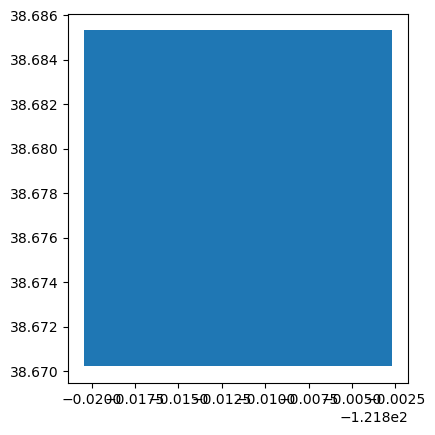

In [2]:
# A LST dataset that covers the whole Woodland
reference_LST_raster =  '../../datasets/satellite_raster_data/All/land_surface_temperature_Veg_US_Crop_876_2018-08-06.tif'
ref_minx, ref_miny, ref_maxx, ref_maxy= rio.open(reference_LST_raster).bounds

# creating a polygon geodataframe/shapefile using reference raster bounding box
# will use this to mask ERA5 datasets
ref_geom = box(ref_minx, ref_miny, ref_maxx, ref_maxy)
ref_gdf = gpd.GeoDataFrame({'id': 1, 'geometry': [ref_geom]})
ref_gdf = ref_gdf.set_crs('EPSG: 4326')
ref_gdf.plot()
ref_gdf.to_file('../shapefiles_grids/LST_Woodland_bbox.shp')

In [3]:
# reference raster for California's AOI (Sacramento)
cities_California_100m_refraster = '../reference_rasters/cities_California_100m_ref_raster.tif'

### 2. Copying `7-9` weather datasets to (4km) `'../datasets/downscaled_data'` directory

In [4]:
# copying min relative humidity dataset
min_rel_humidity_dir = '../../datasets/weather_raster_data/cities_California/era5_data/resampled_4km_rasters_bilinear/min_Rhumid'
min_rel_humidity_copy_dir =  '../../datasets/downscaled_data/4km/weather_data/resampled_4km/min_Rhumid'
copy_file(input_dir_file=min_rel_humidity_dir, copy_dir=min_rel_humidity_copy_dir, search_by='*.tif')


# copying max relative humidity dataset
max_rel_humidity_dir = '../../datasets/weather_raster_data/cities_California/era5_data/resampled_4km_rasters_bilinear/max_Rhumid'
max_rel_humidity_copy_dir = '../../datasets/downscaled_data/4km/weather_data/resampled_4km/max_Rhumid'
copy_file(input_dir_file=max_rel_humidity_dir, copy_dir=max_rel_humidity_copy_dir, search_by='*.tif')


# copying total net solar radiation dataset
tot_net_SR_dir = '../../datasets/weather_raster_data/cities_California/era5_data/resampled_4km_rasters_bilinear/TotNet_SR'
tot_net_SR_copy_dir = '../../datasets/downscaled_data/4km/weather_data/resampled_4km/TotNet_SR'
copy_file(input_dir_file=tot_net_SR_dir, copy_dir=tot_net_SR_copy_dir, search_by='*.tif')

'../../datasets/downscaled_data/4km/weather_data/resampled_4km/MaxNet_SR/MaxNet_SR_20100416.tif'

### 3. Resampling TWC Hi-Res Precipitation (8km) Data to 4km 
Resampling TWC High-Res 8km Precipitation Data to 4km. This TWC dataset starts from 2015-12-01. We will replace modeled precipitation dataset with these high resolution dataset starting from 2015-12-01.

In [3]:
total_precip_8km_dir_twc = '../../datasets/weather_raster_data/cities_California/twc_data/precip_data_8km/total_precip'
total_precip_4km_dir_twc = '../../datasets/weather_raster_data/cities_California/twc_data/resampled_precip_data_4km/total_precip'

ref_raster = '../../datasets/downscaled_data/4km/weather_data/modeled_4km/max_temp/max_temp_20020101.tif'

total_precip_8km_datasets = glob(os.path.join(total_precip_8km_dir_twc, '*.tif'))

# Resampling TWC Hi-Res data from 8km to 4km
for precip_data in total_precip_8km_datasets:
    raster_name = os.path.basename(precip_data)
    resample_raster_based_on_ref_raster(input_raster=precip_data, ref_raster=ref_raster, 
                                        output_dir=total_precip_4km_dir_twc, 
                                        raster_name=raster_name, resampling_alg=Resampling.bilinear,
                                        paste_value_on_ref_raster=False)

### 4. Replacing some modeled datasets with TWC datasets from 2015
We have TWC high resolution data records starting from 2015-06-30 (for precipitation from 2015-12-01). We have modeled high resolution data from 2002 to 2023. Despite that, from 2015 we will use TWC high resolution 4km data. Therefore, we will replace modeled data with TWC datasets from 2015 before compiling all datasets into the 4km ARD.

In [ ]:
# TWC weather datasets
max_temp_dir_twc = '../../datasets/weather_raster_data/cities_California/twc_data/weather_data_4km/max_temp'
min_temp_dir_twc = '../../datasets/weather_raster_data/cities_California/twc_data/weather_data_4km/min_temp'
avg_rel_humid_dir_twc = '../../datasets/weather_raster_data/cities_California/twc_data/weather_data_4km/avg_Rhumid'
avg_wind_speed_dir_twc = '../../datasets/weather_raster_data/cities_California/twc_data/weather_data_4km/avg_wind_speed'
precipitation_dir_twc = '../../datasets/weather_raster_data/cities_California/twc_data/resampled_precip_data_4km/total_precip'


# model interpolated weather datasets 
max_temp_dir_modeled = '../../datasets/downscaled_data/4km/weather_data/modeled_4km/max_temp'
min_temp_dir_modeled = '../../datasets/downscaled_data/4km/weather_data/modeled_4km/min_temp'
avg_rel_humid_dir_modeled = '../../datasets/downscaled_data/4km/weather_data/modeled_4km/avg_Rhumid'
avg_wind_speed_dir_modeled = '../../datasets/downscaled_data/4km/weather_data/modeled_4km/avg_wind_speed'
precipitation_dir_modeled = '../../datasets/downscaled_data/4km/weather_data/modeled_precipitation_resampled_4km/total_precip'  # ML/DL model generated total_precip 



copy_file(input_dir_file=max_temp_dir_twc, copy_dir=max_temp_dir_modeled, search_by='*.tif')
copy_file(input_dir_file=min_temp_dir_twc, copy_dir=min_temp_dir_modeled, search_by='*.tif')
copy_file(input_dir_file=avg_rel_humid_dir_twc, copy_dir=avg_rel_humid_dir_modeled, search_by='*.tif')
copy_file(input_dir_file=avg_wind_speed_dir_twc, copy_dir=avg_wind_speed_dir_modeled, search_by='*.tif')
copy_file(input_dir_file=precipitation_dir_twc, copy_dir=precipitation_dir_modeled, search_by='*.tif')

 ### 5. Copying LST Satellite datasets (100m) to `'../datasets/downscaled_data'` directory

In [4]:
LST_dir = '../../datasets/satellite_raster_data/Woodland/LST_single_band'
LST_copy_dir = '../../datasets/downscaled_data/100m/satellite_data/LST_woodland'

copy_file(input_dir_file=LST_dir, copy_dir=LST_copy_dir, search_by='*.tif')

'../../datasets/downscaled_data/100m/satellite_data/LST_woodland/land_surface_temperature_Veg_US_Crop_887_20190320.tif'

### 6. Resampling > Masking > Resampling weather datasets to 100m

#### Note

The pixel size of weather datasets are of 4km. But the Woodland site itself if less than 4km is x-y direction, therefore, masking the dataset with the "Woodland Site" bounding box will not work. First, we have to first resample the weather data to 100m using our AOI's 100m reference raster. Second, we have to maskthe datasets with Woodland Bbox. Third, we have to resamplethe datasets again (to 100m) to allign the pixels with the LST satellite data's pixels. The following steps will be followed `resample to 100m > mask with Woodland Bbox > resample to 100m with LST reference raster`

Resampling the weather datasets to 100m for the whole AOI (Sacramento) will take up a lot of space, therefore, after resampling the raster and performing the masking+resampling operation, I am deleting the AOI's 100m file. Only storing the masked and resampled 100m raster for the Woodland Bbox.

In [4]:
# model interpolated weather datasets (have TWC datasets from 2015)
max_temp_dir = '../../datasets/downscaled_data/4km/weather_data/modeled_4km/max_temp'
min_temp_dir = '../../datasets/downscaled_data/4km/weather_data/modeled_4km/min_temp'
avg_temp_dir = '../../datasets/downscaled_data/4km/weather_data/modeled_4km/avg_temp'
avg_rel_humid_dir = '../../datasets/downscaled_data/4km/weather_data/modeled_4km/avg_Rhumid'
avg_wind_speed_dir = '../../datasets/downscaled_data/4km/weather_data/modeled_4km/avg_wind_speed'
precipitation_dir = '../../datasets/downscaled_data/4km/weather_data/modeled_precipitation_resampled_4km/total_precip'  # ML/DL model generated total_precip + TWC High-Res resampled 4km precip from 2015


# era5 resampled weather datasets
min_rel_humidity_dir = '../../datasets/downscaled_data/4km/weather_data/resampled_4km/min_Rhumid'
max_rel_humidity_dir = '../../datasets/downscaled_data/4km/weather_data/resampled_4km/max_Rhumid'
total_net_SR_dir = '../../datasets/downscaled_data/4km/weather_data/resampled_4km/TotNet_SR'


all_weather_data_directories_v1 = [max_temp_dir, min_temp_dir, avg_temp_dir, avg_rel_humid_dir, avg_wind_speed_dir,
                                   precipitation_dir, min_rel_humidity_dir, max_rel_humidity_dir, 
                                   total_net_SR_dir]

In [5]:
all_weather_data_directories_v1

['../../datasets/downscaled_data/4km/weather_data/modeled_4km/max_temp',
 '../../datasets/downscaled_data/4km/weather_data/modeled_4km/min_temp',
 '../../datasets/downscaled_data/4km/weather_data/modeled_4km/avg_temp',
 '../../datasets/downscaled_data/4km/weather_data/modeled_4km/avg_Rhumid',
 '../../datasets/downscaled_data/4km/weather_data/modeled_4km/avg_wind_speed',
 '../../datasets/downscaled_data/4km/weather_data/modeled_precipitation_resampled_4km/total_precip',
 '../../datasets/downscaled_data/4km/weather_data/resampled_4km/min_Rhumid',
 '../../datasets/downscaled_data/4km/weather_data/resampled_4km/max_Rhumid',
 '../../datasets/downscaled_data/4km/weather_data/resampled_4km/TotNet_SR']

In [ ]:
output_dir = '../../datasets/downscaled_data/100m/weather_data/V1'
bbox= '../shapefiles_grids/LST_Woodland_bbox.shp'
sacramento_ref_raster = cities_California_100m_refraster
woodland_ref_raster = '../../datasets/satellite_raster_data/All/land_surface_temperature_Veg_US_Crop_876_2018-08-06.tif'

resample_mask_resample_weather_datasets_to_shapefile(input_data_dir_list=all_weather_data_directories_v1, 
                                                     output_main_dir=output_dir, masking_shapefile=bbox, 
                                                     target_raster_whole_aoi=sacramento_ref_raster, 
                                                     target_raster_smaller_aoi=woodland_ref_raster)

Resampling > Masking > Resampling data for max_temp...
Resampling > Masking > Resampling data for min_temp...
Resampling > Masking > Resampling data for avg_temp...
Resampling > Masking > Resampling data for avg_Rhumid...
Resampling > Masking > Resampling data for avg_wind_speed...
Resampling > Masking > Resampling data for total_precip...
Resampling > Masking > Resampling data for min_Rhumid...


### 7. Compiling weather + satellite datasets to multiple `preARD` dataframes

Weather + satellite datasets have extended daily records, therefore, compiling weather datasets into multiple dataframe (referring to as `preARD`). These `preARD` dataframes will be combined into a single dataframe and averaged to form the 100m weather ARD.

In [4]:
######### 100m weather datasets ############# 

# model interpolated weather datasets (these datasets were first downscaled by ML/DL model to 4km-8km and then resampled to 100m)
max_temp_dir = '../../datasets/downscaled_data/100m/weather_data/V1/max_temp'
min_temp_dir = '../../datasets/downscaled_data/100m/weather_data/V1/min_temp'
avg_temp_dir = '../../datasets/downscaled_data/100m/weather_data/V1/avg_temp'
avg_rel_humid_dir = '../../datasets/downscaled_data/100m/weather_data/V1/avg_Rhumid'
avg_wind_speed_dir = '../../datasets/downscaled_data/100m/weather_data/V1/avg_wind_speed'
precipitation_dir = '../../datasets/downscaled_data/100m/weather_data/V1/total_precip'  # ML/DL model generated total_precip 


# era5 resampled weather datasets (these datasets were directly resampled from ERA5 28km to 100m)
min_rel_humidity_dir = '../../datasets/downscaled_data/100m/weather_data/V1/min_Rhumid'
max_rel_humidity_dir = '../../datasets/downscaled_data/100m/weather_data/V1/max_Rhumid'
total_net_SR_dir = '../../datasets/downscaled_data/100m/weather_data/V1/TotNet_SR'


all_weather_data_100m_v1 = [max_temp_dir, min_temp_dir, avg_temp_dir, avg_rel_humid_dir, avg_wind_speed_dir,
                            precipitation_dir, min_rel_humidity_dir, max_rel_humidity_dir, total_net_SR_dir]

all_weather_data_100m_v1

['../../datasets/downscaled_data/100m/weather_data/V1/max_temp',
 '../../datasets/downscaled_data/100m/weather_data/V1/min_temp',
 '../../datasets/downscaled_data/100m/weather_data/V1/avg_temp',
 '../../datasets/downscaled_data/100m/weather_data/V1/avg_Rhumid',
 '../../datasets/downscaled_data/100m/weather_data/V1/avg_wind_speed',
 '../../datasets/downscaled_data/100m/weather_data/V1/total_precip',
 '../../datasets/downscaled_data/100m/weather_data/V1/min_Rhumid',
 '../../datasets/downscaled_data/100m/weather_data/V1/max_Rhumid',
 '../../datasets/downscaled_data/100m/weather_data/V1/TotNet_SR']

__satellite data will be given input in the folowing function separately because it doesn't have the same daily coverage as the weather data and can cause unequal array issue while being compiled with the weather datasets.__

In [9]:
weather_data_directories_v1 = all_weather_data_100m_v1
satellite_data_directories = ['../../datasets/downscaled_data/100m/satellite_data/LST_woodland']


create_weather_satellite_100m_preARD_dataframes(weather_data_directories_list=weather_data_directories_v1, 
                                                satellite_data_directories_list = satellite_data_directories,
                                                output_folder='../../datasets/ARD/100m', 
                                                savename='weather_satellite_data_100m_preARD_V1', 
                                                dataset_in_each_chunk=3)

compiling data for max_temp...
compiling data for min_temp...
compiling data for avg_Rhumid...
compiling data for avg_wind_speed...
compiling data for total_precip...
compiling data for avg_temp...
compiling data for min_Rhumid...
compiling data for max_Rhumid...
compiling data for TotNet_SR...
compiling data for LST_woodland...


### 8. Generating Weather+Satellite ARD 100m
Compiling the preARD dataframes into a single dataframe. This single dataframe is our `100m resolution ARD V1`.

In [10]:
weather_satellite_ard_df_v1 = compile_preARD_multiDF_to_ARD(parquet_folder='../../datasets/ARD/100m/weather_satellite_data_100m_preARD_V1', 
                                                  output_folder='../../datasets/ARD/100m', 
                                                  savename='weather_satellite_100m_ARD_Woodland_V1.parquet')

In [11]:
weather_satellite_ard_df_v1

,month_day,lat,lon,LST_woodland,avg_temp,min_Rhumid,max_Rhumid,TotNet_SR,avg_wind_speed,total_precip,max_temp,min_temp,avg_Rhumid
0,01_01,38.670667,-121.816444,6.907501,8.061663,33.431217,78.158134,8.308899,11.084865,0.035342,13.168329,2.783760,61.957291
1,01_01,38.670667,-121.815556,6.834999,8.055140,33.451252,78.180573,8.309107,11.076511,0.036135,13.166052,2.783000,62.000580
2,01_01,38.670667,-121.814667,6.779999,8.048616,33.471291,78.203011,8.309315,11.068157,0.036929,13.163774,2.782241,62.043865
3,01_01,38.670667,-121.813778,7.447495,8.042093,33.491325,78.225449,8.309522,11.059804,0.037723,13.161495,2.781482,62.087151
4,01_01,38.670667,-121.812889,6.995003,8.035570,33.511360,78.247879,8.309729,11.051450,0.038517,13.159217,2.780722,62.130440
...,...,...,...,...,...,...,...,...,...,...,...,...,...
73927,12_31,38.684889,-121.815556,6.096002,9.585676,36.521149,86.334068,7.712244,13.881453,0.462623,13.252660,4.064751,68.257095
73928,12_31,38.684889,-121.814667,6.515997,9.581711,36.535896,86.351791,7.712217,13.869690,0.466011,13.248056,4.056056,68.306709
73929,12_31,38.684889,-121.813778,6.783997,9.577745,36.550640,86.369522,7.712190,13.857927,0.469399,13.243454,4.047362,68.356308
73930,12_31,38.684889,-121.812889,6.221997,9.573781,36.565384,86.387253,7.712164,13.846164,0.472788,13.238851,4.038668,68.405930


In [12]:
## number of records in a particulat month_day
single_day_df = weather_satellite_ard_df_v1[weather_satellite_ard_df_v1['month_day']=='01_02']
len(single_day_df)

202

`For a single mm_dd, there are 202 rows of record each having 100m pixel size.`

--------------------------

------------------------

# V2 (with resampled precipitation)

As the precipitation model didn't perform well, we will use resampled (directly from 28km ERA5 data to 100mm) precipitation data in the ARD and observe the environmental clustering model performance.

### 1. Loading reference raster and ROI shapefile
The 100m ARD is only processed for the `Woodland site` as satellite Land Surface Temperature data is available for Woodland site only for the time being.

We are choosing a LST dataset over Woodland as the refernece raster and will use it to process LST, soil, elevation, and weather datasets over Woodland.

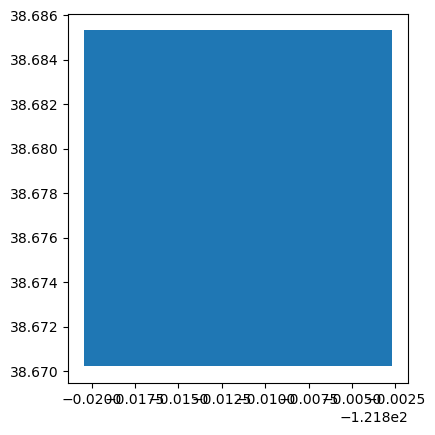

In [13]:
# A LST dataset that covers the whole Woodland
reference_LST_raster =  '../../datasets/satellite_raster_data/All/land_surface_temperature_Veg_US_Crop_876_2018-08-06.tif'
ref_minx, ref_miny, ref_maxx, ref_maxy= rio.open(reference_LST_raster).bounds

# creating a polygon geodataframe/shapefile using reference raster bounding box
# will use this to mask ERA5 datasets
ref_geom = box(ref_minx, ref_miny, ref_maxx, ref_maxy)
ref_gdf = gpd.GeoDataFrame({'id': 1, 'geometry': [ref_geom]})
ref_gdf = ref_gdf.set_crs('EPSG: 4326')
ref_gdf.plot()
ref_gdf.to_file('../shapefiles_grids/LST_Woodland_bbox.shp')

In [14]:
# reference raster for California's AOI (Sacramento)
cities_California_100m_refraster = '../reference_rasters/cities_California_100m_ref_raster.tif'

### 2. Copying `7-9` weather datasets to (4km) `'../datasets/downscaled_data'` directory
This step was performed during 4km ARD and 100m ARD V1 processing. Commenting it out.

In [15]:
# # copying min relative humidity dataset
# min_rel_humidity_dir = '../../datasets/weather_raster_data/cities_California/era5_data/resampled_4km_rasters_bilinear/min_Rhumid'
# min_rel_humidity_copy_dir =  '../../datasets/downscaled_data/4km/weather_data/resampled_4km/min_Rhumid'
# copy_file(input_dir_file=min_rel_humidity_dir, copy_dir=min_rel_humidity_copy_dir, search_by='*.tif')


# # copying max relative humidity dataset
# max_rel_humidity_dir = '../../datasets/weather_raster_data/cities_California/era5_data/resampled_4km_rasters_bilinear/max_Rhumid'
# max_rel_humidity_copy_dir = '../../datasets/downscaled_data/4km/weather_data/resampled_4km/max_Rhumid'
# copy_file(input_dir_file=max_rel_humidity_dir, copy_dir=max_rel_humidity_copy_dir, search_by='*.tif')


# # copying total net solar radiation dataset
# tot_net_SR_dir = '../../datasets/weather_raster_data/cities_California/era5_data/resampled_4km_rasters_bilinear/TotNet_SR'
# tot_net_SR_copy_dir = '../../datasets/downscaled_data/4km/weather_data/resampled_4km/TotNet_SR'
# copy_file(input_dir_file=tot_net_SR_dir, copy_dir=tot_net_SR_copy_dir, search_by='*.tif')

### 3. Resampling TWC Hi-Res Precipitation (8km) Data to 4km 
Resampling TWC High-Res 8km Precipitation Data to 4km. This TWC dataset starts from 2015-12-01. We will replace modeled precipitation dataset with these high resolution dataset starting from 2015-12-01.

This step was performed in 4km ARD creation. Commenting out the step.

In [16]:
# total_precip_8km_dir_twc = '../../datasets/weather_raster_data/cities_California/twc_data/precip_data_8km/total_precip'
# total_precip_4km_dir_twc = '../../datasets/weather_raster_data/cities_California/twc_data/resampled_precip_data_4km/total_precip'

# ref_raster = '../../datasets/downscaled_data/4km/weather_data/modeled_4km/max_temp/max_temp_20020101.tif'

# total_precip_8km_datasets = glob(os.path.join(total_precip_8km_dir_twc, '*.tif'))

# # Resampling TWC Hi-Res data from 8km to 4km
# for precip_data in total_precip_8km_datasets:
#     raster_name = os.path.basename(precip_data)
#     resample_raster_based_on_ref_raster(input_raster=precip_data, ref_raster=ref_raster, 
#                                         output_dir=total_precip_4km_dir_twc, 
#                                         raster_name=raster_name, resampling_alg=Resampling.bilinear,
#                                         paste_value_on_ref_raster=False)

### 4. Replacing some modeled datasets with TWC datasets from 2015
We have TWC high resolution data records starting from 2015-06-30 (for precipitation from 2015-12-01). We have modeled high resolution data from 2002 to 2023. Despite that, from 2015 we will use TWC high resolution 4km data. Therefore, we will replace modeled data with TWC datasets from 2015 before compiling all datasets into the ARD.

We already copied `max_temp`, `min_temp`, `avg_rel_humidity`, and `avg_wind_speed` TWC data to modeled data folder in V1 ARD procesing. Commenting Out those steps in the following block. Only copying resampled 4km TWC High-Res Precipitation data to resampled ERA5 Precipitation folder.

In [17]:
# TWC weather datasets
# max_temp_dir_twc = '../../datasets/weather_raster_data/cities_California/twc_data/weather_data_4km/max_temp'
# min_temp_dir_twc = '../../datasets/weather_raster_data/cities_California/twc_data/weather_data_4km/min_temp'
# avg_rel_humid_dir_twc = '../../datasets/weather_raster_data/cities_California/twc_data/weather_data_4km/avg_Rhumid'
# avg_wind_speed_dir_twc = '../../datasets/weather_raster_data/cities_California/twc_data/weather_data_4km/avg_wind_speed'
precipitation_dir_twc = '../../datasets/weather_raster_data/cities_California/twc_data/resampled_precip_data_4km/total_precip'


# model interpolated weather datasets
# max_temp_dir_modeled = '../../datasets/downscaled_data/4km/weather_data/modeled_4km/max_temp'
# min_temp_dir_modeled = '../../datasets/downscaled_data/4km/weather_data/modeled_4km/min_temp'
# avg_rel_humid_dir_modeled = '../../datasets/downscaled_data/4km/weather_data/modeled_4km/avg_Rhumid'
# avg_wind_speed_dir_modeled = '../../datasets/downscaled_data/4km/weather_data/modeled_4km/avg_wind_speed'

## ERA5 resampled precipitation folder
precipitation_dir_era5_resampled = '../../datasets/downscaled_data/4km/weather_data/resampled_4km/total_precip'  # era5 resampled total_precip (2002-2015) + TWC resampled precip after 2015 



# copy_file(input_dir_file=max_temp_dir_twc, copy_dir=max_temp_dir_modeled, search_by='*.tif')
# copy_file(input_dir_file=min_temp_dir_twc, copy_dir=min_temp_dir_modeled, search_by='*.tif')
# copy_file(input_dir_file=avg_rel_humid_dir_twc, copy_dir=avg_rel_humid_dir_modeled, search_by='*.tif')
# copy_file(input_dir_file=avg_wind_speed_dir_twc, copy_dir=avg_wind_speed_dir_modeled, search_by='*.tif')
copy_file(input_dir_file=precipitation_dir_twc, copy_dir=precipitation_dir_era5_resampled, search_by='*.tif')

'../../datasets/downscaled_data/4km/weather_data/resampled_4km/total_precip/total_precip_20181212.tif'

 ### 5. Copying LST Satellite datasets (100m) to `'../datasets/downscaled_data'` directory
 This step was performed once in 100m ARD V1 processing. Commenting it out.

In [18]:
# LST_dir = '../../datasets/satellite_raster_data/Woodland/LST_single_band'
# LST_copy_dir = '../../datasets/downscaled_data/100m/satellite_data/LST_woodland'

# copy_file(input_dir_file=LST_dir, copy_dir=LST_copy_dir, search_by='*.tif')

### 6. Resampling > Masking > Resampling weather datasets to 100m

#### Note

The pixel size of weather datasets are of 4km. But the Woodland site itself if less than 4km is x-y direction, therefore, masking the dataset with the "Woodland Site" bounding box will not work. First, we have to first resample the weather data to 100m using our AOI's 100m reference raster. Second, we have to maskthe datasets with Woodland Bbox. Third, we have to resamplethe datasets again (to 100m) to allign the pixels with the LST satellite data's pixels. The following steps will be followed `resample to 100m > mask with Woodland Bbox > resample to 100m with LST reference raster`

Resampling the weather datasets to 100m for the whole AOI (Sacramento) will take up a lot of space, therefore, after resampling the raster and performing the masking+resampling operation, I am deleting the AOI's 100m file. Only storing the masked and resampled 100m raster for the Woodland Bbox.

### 6.1. Copying weather datasets except precipitation to a `V2` folder

The 4km modeled weather datasets have already been processed through `resampled (100m) > masked > resampled` processes in 100m ARD V1 processing. We will copy these processed datasets to a `V2` folder `except modeled precipitation` as in V2 version we will use directly resampled ERA5 preceipitation in the ARD.

In [19]:
# copying min relative humidity dataset
weather_data_dir = '../../datasets/downscaled_data/100m/weather_data/V1'
datasets_to_copy = os.listdir(weather_data_dir)
datasets_to_copy = [i for i in datasets_to_copy if 'total_precip' not in i]

main_output_folder = '../../datasets/downscaled_data/100m/weather_data/V2'

for i in datasets_to_copy:
    print(f'Copying processed 100m dataset for {i}.....')
    
    # folder to copy
    dir_to_copy = os.path.join(weather_data_dir, i)
    
    # folder where files will be copied
    output_folder = os.path.join(main_output_folder, i)
    
    # copying
    copy_file(input_dir_file=dir_to_copy, copy_dir=output_folder, search_by='*.tif')

Copying processed 100m dataset for avg_wind_speed.....
Copying processed 100m dataset for TotNet_SR.....
Copying processed 100m dataset for min_Rhumid.....
Copying processed 100m dataset for avg_Rhumid.....
Copying processed 100m dataset for max_temp.....
Copying processed 100m dataset for max_Rhumid.....
Copying processed 100m dataset for avg_temp.....
Copying processed 100m dataset for min_temp.....


### 6.2. Resampling>masking>Resampling weather datasets to 100m

__As all datasets, except the directly `resampled 4km total precipitation` has already gone through the `resample > mask > resample` processes, only performing the `resample > mask > resample` operation on the `resampled 4km total precipitation` dataset.__

In [20]:
# era5 directly resampled precipitation dataset
precipitation_dir = '../../datasets/downscaled_data/4km/weather_data/resampled_4km/total_precip'  ###### resampled total_precip (not ML/DL model interpolated)

In [ ]:
output_dir = '../../datasets/downscaled_data/100m/weather_data/V2'
bbox= '../shapefiles_grids/LST_Woodland_bbox.shp'
sacramento_ref_raster = cities_California_100m_refraster
woodland_ref_raster = '../../datasets/satellite_raster_data/All/land_surface_temperature_Veg_US_Crop_876_2018-08-06.tif'

all_weather_data_directories_v2 = [precipitation_dir]

resample_mask_resample_weather_datasets_to_shapefile(input_data_dir_list=all_weather_data_directories_v2, 
                                                     output_main_dir=output_dir, masking_shapefile=bbox, 
                                                     target_raster_whole_aoi=sacramento_ref_raster, 
                                                     target_raster_smaller_aoi=woodland_ref_raster)

Resampling > Masking > Resampling data for total_precip...


### 7. Compiling weather+satellite datasets to multiple `preARD` dataframes

__Weather datasets have extended daily records, therefore, compiling weather datasets into multiple dataframe (referring to as `preARD`. These `preARD` dataframes will be combined into a single dataframe and averaged to form the 100m weather+satellite ARD.__

In [4]:
######### 100m weather datasets ############# 

# model interpolated weather datasets (these datasets were first downscaled by ML/DL model to 4km-8km and then resampled to 100m)
max_temp_dir = '../../datasets/downscaled_data/100m/weather_data/V2/max_temp'
min_temp_dir = '../../datasets/downscaled_data/100m/weather_data/V2/min_temp'
avg_temp_dir = '../../datasets/downscaled_data/100m/weather_data/V2/avg_temp'
avg_rel_humid_dir = '../../datasets/downscaled_data/100m/weather_data/V2/avg_Rhumid'
avg_wind_speed_dir = '../../datasets/downscaled_data/100m/weather_data/V2/avg_wind_speed'

# era5 resampled weather datasets (these datasets were directly resampled from ERA5 28km to 100m)
min_rel_humidity_dir = '../../datasets/downscaled_data/100m/weather_data/V2/min_Rhumid'
max_rel_humidity_dir = '../../datasets/downscaled_data/100m/weather_data/V2/max_Rhumid'
total_net_SR_dir = '../../datasets/downscaled_data/100m/weather_data/V2/TotNet_SR'
precipitation_dir = '../../datasets/downscaled_data/100m/weather_data/V2/total_precip'   ###### resampled total_precip (not ML/DL model interpolated)


all_weather_data_100m_v2 = [max_temp_dir, min_temp_dir, avg_temp_dir, avg_rel_humid_dir, avg_wind_speed_dir,
                            min_rel_humidity_dir, max_rel_humidity_dir, total_net_SR_dir, precipitation_dir, ]

all_weather_data_100m_v2

['../../datasets/downscaled_data/100m/weather_data/V2/max_temp',
 '../../datasets/downscaled_data/100m/weather_data/V2/min_temp',
 '../../datasets/downscaled_data/100m/weather_data/V2/avg_temp',
 '../../datasets/downscaled_data/100m/weather_data/V2/avg_Rhumid',
 '../../datasets/downscaled_data/100m/weather_data/V2/avg_wind_speed',
 '../../datasets/downscaled_data/100m/weather_data/V2/min_Rhumid',
 '../../datasets/downscaled_data/100m/weather_data/V2/max_Rhumid',
 '../../datasets/downscaled_data/100m/weather_data/V2/TotNet_SR',
 '../../datasets/downscaled_data/100m/weather_data/V2/total_precip']

In [5]:
weather_data_directories_v2 = all_weather_data_100m_v2
satellite_data_directories = ['../../datasets/downscaled_data/100m/satellite_data/LST_woodland']


create_weather_satellite_100m_preARD_dataframes(weather_data_directories_list=weather_data_directories_v2, 
                                                satellite_data_directories_list = satellite_data_directories,
                                                output_folder='../../datasets/ARD/100m', 
                                                savename='weather_satellite_data_100m_preARD_V2', 
                                                dataset_in_each_chunk=3)

compiling data for max_temp...
compiling data for min_temp...
compiling data for avg_Rhumid...
compiling data for avg_wind_speed...
compiling data for total_precip...
compiling data for avg_temp...
compiling data for min_Rhumid...
compiling data for max_Rhumid...
compiling data for TotNet_SR...
compiling data for LST_woodland...


### 8. Generating Weather+Satellite ARD 100m
Compiling the preARD dataframes into a single dataframe. This single dataframe is our `100m resolution ARD V2`.

In [6]:
weather_satellite_ard_df_v2 = compile_preARD_multiDF_to_ARD(parquet_folder='../../datasets/ARD/100m/weather_satellite_data_100m_preARD_V2', 
                                                  output_folder='../../datasets/ARD/100m', 
                                                  savename='weather_satellite_100m_ARD_Woodland_V2.parquet')

In [7]:
weather_satellite_ard_df_v2

,month_day,lat,lon,LST_woodland,max_temp,min_temp,avg_Rhumid,avg_temp,min_Rhumid,max_Rhumid,TotNet_SR,avg_wind_speed,total_precip
0,01_01,38.670667,-121.816444,6.907501,13.168329,2.783760,61.957291,8.061663,33.431217,78.158134,8.308899,11.084865,0.035342
1,01_01,38.670667,-121.815556,6.834999,13.166052,2.783000,62.000580,8.055140,33.451252,78.180573,8.309107,11.076511,0.036135
2,01_01,38.670667,-121.814667,6.779999,13.163774,2.782241,62.043865,8.048616,33.471291,78.203011,8.309315,11.068157,0.036929
3,01_01,38.670667,-121.813778,7.447495,13.161495,2.781482,62.087151,8.042093,33.491325,78.225449,8.309522,11.059804,0.037723
4,01_01,38.670667,-121.812889,6.995003,13.159217,2.780722,62.130440,8.035570,33.511360,78.247879,8.309729,11.051450,0.038517
...,...,...,...,...,...,...,...,...,...,...,...,...,...
73927,12_31,38.684889,-121.815556,6.096002,13.252660,4.064751,68.257095,9.585676,36.521149,86.334068,7.712244,13.881453,0.462623
73928,12_31,38.684889,-121.814667,6.515997,13.248056,4.056056,68.306709,9.581711,36.535896,86.351791,7.712217,13.869690,0.466011
73929,12_31,38.684889,-121.813778,6.783997,13.243454,4.047362,68.356308,9.577745,36.550640,86.369522,7.712190,13.857927,0.469399
73930,12_31,38.684889,-121.812889,6.221997,13.238851,4.038668,68.405930,9.573781,36.565384,86.387253,7.712164,13.846164,0.472788
